![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [39]:
from tensorflow import keras as ks
from tensorflow.keras.applications import vgg16
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2
import random
import pandas as pd
import time
import datetime

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [41]:
import keras

In [42]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_val = keras.utils.to_categorical(y_val, num_classes=10)

In [43]:
print("Etiquetas de train:", y_train)


# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()


print("Etiquetas de train (en vector):", y_train)


Etiquetas de train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Etiquetas de train (en vector): [0. 0. 0. ... 0. 0. 0.]


In [44]:
y_train.shape

(500000,)

In [45]:
x_train.shape

(50000, 32, 32, 3)

Obtenemos un array con todas las labels de CIFAR10

In [46]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(500000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


TypeError: ignored

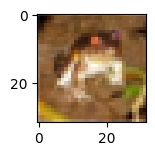

In [47]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [48]:
x_val_scaled = x_train_scaled
y_val = y_train

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

Montamos la Red Neuronal
Cargar la parte de extraccion de features de VGG16

In [49]:
from tensorflow.keras.models import Model

In [50]:
model1 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))# SON LOS PIXELES DE LAS IMAGENES
#  INLUDE TOP FALSE ES PARA SOLO AGARRAR LA PARTE QUE NECESITAMOS SOLO las convulaciones ni el faltten esta incorporado
model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Desde aca le extraemos la ultima capa del modelo y se la asiganmos a una variable despues a esa variable le asignamos la funcion flatten para que aplane la salida que es el output del modelo

In [51]:
model_post = ks.Sequential()

model_post.add(ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_post.add(ks.layers.Conv2D(32, (3, 3), activation='relu'))
model_post.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))
model_post.add(ks.layers.Dropout(0.20))

model_post.add(ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_post.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model_post.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))
model_post.add(ks.layers.Dropout(0.20))

model_post.add(ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_post.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model_post.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))
model_post.add(ks.layers.Dropout(0.25))

model_post.add(ks.layers.Flatten())
model_post.add(ks.layers.Dense(512, activation='relu'))
model_post.add(ks.layers.Dropout(0.5))

model_post.add(ks.layers.Dense(10, activation='softmax'))

model_post.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 64)        36928     
                                                      

In [56]:
output = model_post.layers[-1].output  # en este extraemos la ultima capa y la asignamos a esa variable
output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_7')>

In [57]:
output_layer = ks.layers.Flatten()(output)# en esta en la ultima capa le asignamos el flatten osea en la variable
output_layer

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'flatten_5')>

In [58]:
model_prevgg16 = Model(model_post.input, output_layer)
model_prevgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18_input (InputLayer  [(None, 32, 32, 3)]      0         
 )                                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 15, 15, 64)        1849

optimizador

In [59]:
new_adam = Adam(learning_rate=0.0005)

In [60]:
model_post.compile(optimizer='Adam',
              loss='sparce_categorical_crossentropy',
              metrics=['accuracy'])

EarlyStopping

In [61]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [62]:
t = time.perf_counter()

In [63]:
history = model_post.fit(x=model_post, y=y_train, batch_size=512,
                             epochs=100, callbacks=[callback_val_loss, callback_val_accuracy],
                             validation_data=(x_val_postvgg16, y_val))

elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))


ValueError: ignored

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:04:13.931530


In [ ]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('Test del Modelo con Data Augmentation > %.3f' % (acc * 100.0))

Test del Modelo con Data Augmentation > 81.020


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

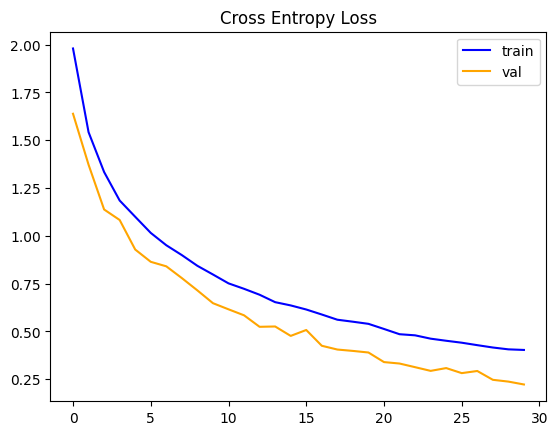

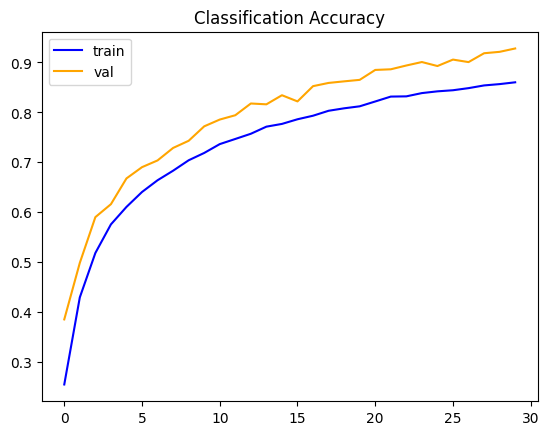

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


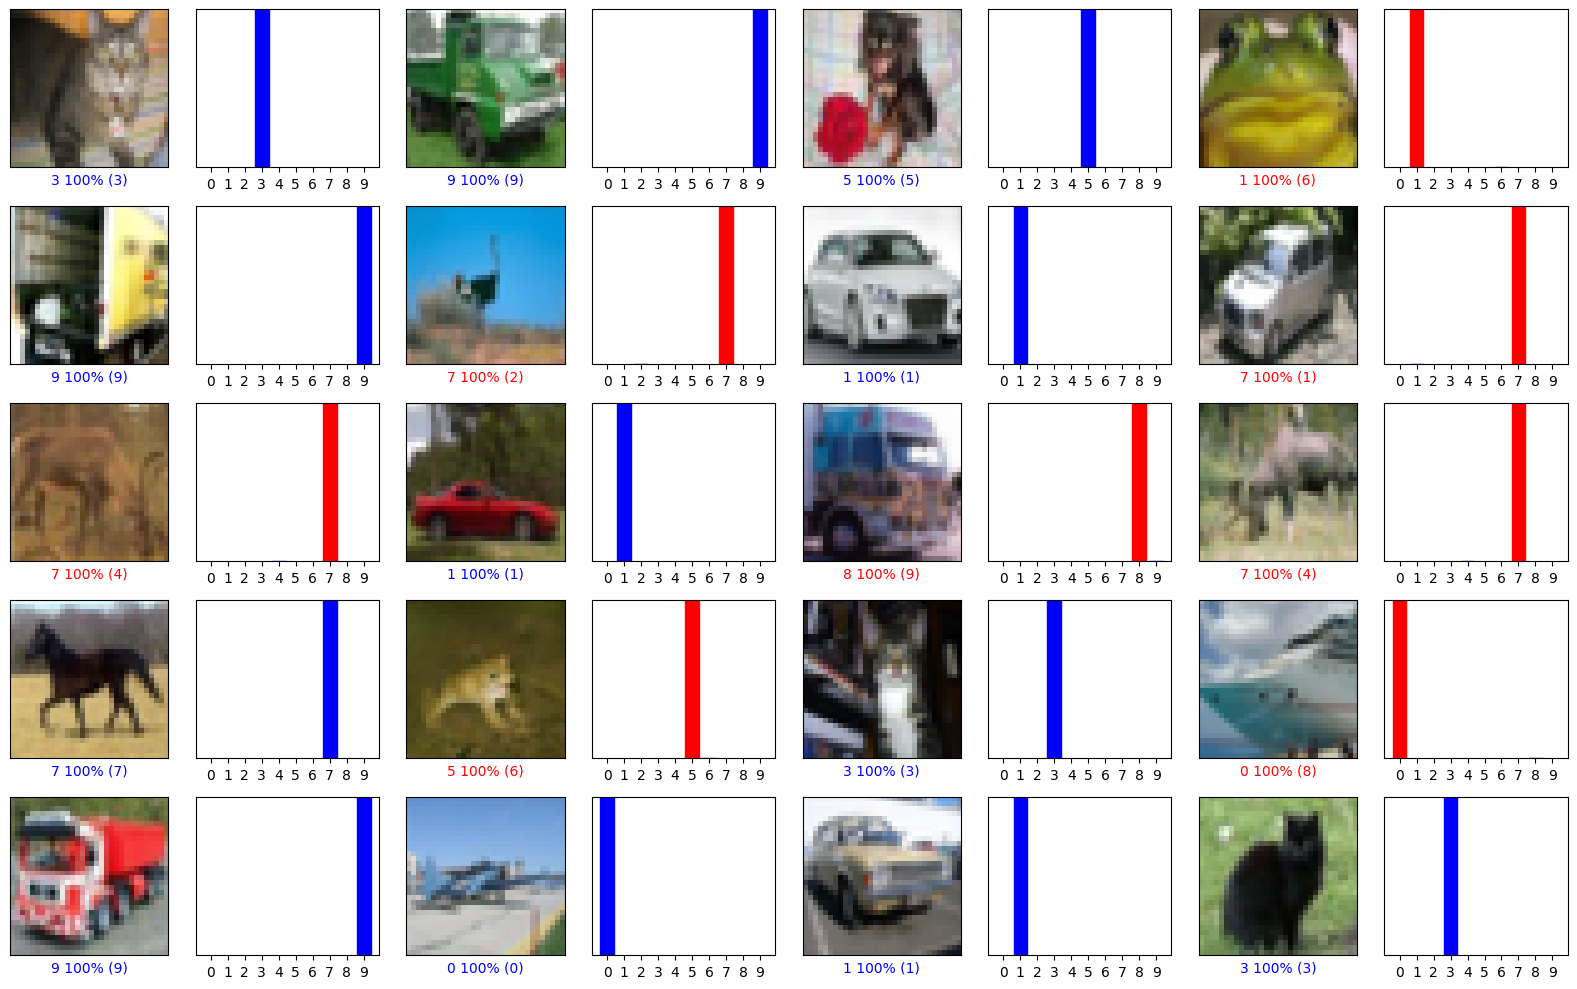

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
ruta_googledrive = "/content/drive/MyDrive/" # A revisar en vuestra instancia

model.save(ruta_googledrive+'cifar10_base_model.h5')

# Ya terminado en este modelo quedamos con 68.75% una mejora de 8.39% ya que inicialmente empezamos con un 57.10 , en este modelo no le hicimos una gran cosa, vamos paso a paso en esta instancia lo unico que hice fue aumentar 2 capas no faltar ninguna regla inamovible que son las entradas y salidas y jugar con el numero de neuronas, NEXT